<h1>10. Add reforecast wind data

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import json
import os
from scipy.interpolate import interp2d
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Define lead times
lead_times = list(range(0, 145, 3))

# Load wind power plant (WPP) data
with open(r"E:\MA_data\WPPs+production\WPPs+production_new_complete.json", "r", encoding="utf-8") as f:
    wpps = json.load(f)

lead_time_dicts = {str(lt): {} for lt in lead_times}  # Initialize empty structure

# Forecast file directory
forecast_dir = r"E:\MA_data\reforecast data ECMWF raw"

# Process each GRIB file (one per month-year)
grib_files = sorted([f for f in os.listdir(forecast_dir) if f.endswith(".grib")])

for grib_file in grib_files:

    # Output JSON file path for this month-year
    output_json_file = os.path.join(r"E:\MA_data\WPPs+production+reforecast_monthwise", f"{grib_file.replace('.grib', '_wind.json')}")

    # Check if this month's data has already been processed
    if os.path.exists(output_json_file):
        print(f"Skipping {grib_file} (already processed)")
        continue  # Skip to the next GRIB file

    print(f"Processing {grib_file}")
        
    _, year, month = grib_file.replace(".grib", "").split("_")
    year, month = int(year), int(month)
    grib_path = os.path.join(forecast_dir, grib_file)

    # Load wind speed forecast data
    try:
        ds = xr.open_dataset(grib_path, engine="cfgrib", chunks={"time": 100})
    except Exception as e:
        print(f"Error reading {grib_file}: {e} --> skipping")
        continue

    # Extract forecast timestamps and wind components
    times = pd.to_datetime(ds["valid_time"].values)
    latitudes = ds["latitude"].values
    longitudes = ds["longitude"].values
    u = ds["u100"].values
    v = ds["v100"].values

    # Process each WPP
    for i, wpp in enumerate(wpps):
        
        json_id = wpp["JSON-ID"]
        wpp_id = wpp["ID_The-Wind-Power"]
        unique_key = f"{json_id}_{wpp_id}"  # Unique identifier of a wpp

        lon = wpp["Longitude"]
        lat = wpp["Latitude"]

        # Convert production timestamps to pandas datetime format
        date_range = pd.to_datetime([entry[0] for entry in wpp["Production"]])
        production_values = [entry[1] for entry in wpp["Production"]]

        # Filter production data for this month-year
        month_mask = (date_range.year == year) & (date_range.month == month)
        production_df = pd.DataFrame({"date": date_range[month_mask], "production": np.array(production_values)[month_mask]})

        if production_df["production"].empty:
            print(f"WPP {i+1}/{len(wpps)} has no production data for {year}/{month}, skipping...")
            continue

        print(f"WPP {i+1}/{len(wpps)} for year {year}/{month}")

        forecast_data = []

        for _, row in production_df.iterrows():
            timestep = row["date"]
            production = row["production"]
            for j in range(len(times)):
                forecast_times = times[j]
                if timestep in forecast_times:
                    forecast_times = pd.DatetimeIndex(forecast_times) # convert from DatetimeArray to DatetimeIndex, because only this one has .get_loc()
                    time_index = forecast_times.get_loc(timestep)
                    lead_time = lead_times[time_index]

                    forecast_u = u[j]
                    forecast_v = v[j]

                    wind_speeds = np.sqrt(forecast_u[time_index]**2 + forecast_v[time_index]**2)
                    spatial_interpolator = interp2d(longitudes, latitudes, wind_speeds, kind='linear')
                    wind_speed_value = spatial_interpolator(lon, lat)[0]
                    wind_speed_value = round(wind_speed_value, 2)

                    forecast_data.append([lead_time, timestep, production, wind_speed_value])

        forecast_df = pd.DataFrame(forecast_data, columns=["lead_time", "forecast_time", "production", "wind_speed"])

        # Store data in structured dictionary grouped by lead time
        for lead_time in lead_times:
            lead_time_str = str(lead_time)  # Ensure keys are strings for JSON compatibility

            # Select data points corresponding to this lead time
            lead_time_mask = forecast_df["lead_time"] == lead_time
            lead_time_data = forecast_df[lead_time_mask]

            if lead_time_data.empty:
                continue  # Skip if no data for this lead time

            # Initialize new WPP entry
            lead_time_dicts[lead_time_str][unique_key] = {
                "Name": wpp["Name"],
                "Names_UK_Plants": wpp["Names_UK_Plants"],
                "Code": wpp["Code"],
                "Type": wpp["Type"],
                "Capacity": wpp["Capacity"],
                "Continent": wpp["Continent"],
                "ISO_code": wpp["ISO_code"],
                "Country": wpp["Country"],
                "State_code": wpp["State_code"],
                "Area": wpp["Area"],
                "City": wpp["City"],
                "Name_TWP": wpp["Name_TWP"],
                "Second_name": wpp["Second_name"],
                "Latitude": wpp["Latitude"],
                "Longitude": wpp["Longitude"],
                "Altitude_Depth": wpp["Altitude_Depth"],
                "Location_accuracy": wpp["Location_accuracy"],
                "Shore_distance_km": wpp["Shore_distance_km"],
                "Manufacturer": wpp["Manufacturer"],
                "Turbine": wpp["Turbine"],
                "Hub_height": wpp["Hub_height"],
                "Number_of_turbines": wpp["Number_of_turbines"],
                "Developer": wpp["Developer"],
                "Operator": wpp["Operator"],
                "Owner": wpp["Owner"],
                "Commissioning_date": wpp["Commissioning_date"],
                "Status": wpp["Status"],
                "Decommissioning_date": wpp["Decommissioning_date"],
                "Source_link": wpp["Source_link"],
                "Last_update": wpp["Last_update"],
                "Time Series": [[str(date), production, wind_speed] for _, date, production, wind_speed in lead_time_data[["lead_time", "forecast_time", "production", "wind_speed"]].values.tolist()]
            }

    # Save updated JSON
    with open(output_json_file, "w", encoding="utf-8") as f:
        json.dump(lead_time_dicts, f, indent=4)

    print(f"Updated JSON file saved: {output_json_file}")

Skipping europe_2015_01.grib (already processed)
Skipping europe_2015_02.grib (already processed)
Skipping europe_2015_03.grib (already processed)
Skipping europe_2015_04.grib (already processed)
Skipping europe_2015_05.grib (already processed)
Skipping europe_2015_06.grib (already processed)
Skipping europe_2015_07.grib (already processed)
Skipping europe_2015_08.grib (already processed)
Skipping europe_2015_09.grib (already processed)
Skipping europe_2015_10.grib (already processed)
Skipping europe_2015_11.grib (already processed)
Skipping europe_2015_12.grib (already processed)
Skipping europe_2016_01.grib (already processed)
Skipping europe_2016_02.grib (already processed)
Skipping europe_2016_03.grib (already processed)
Skipping europe_2016_04.grib (already processed)
Skipping europe_2016_05.grib (already processed)
Skipping europe_2016_06.grib (already processed)
Skipping europe_2016_07.grib (already processed)
Skipping europe_2016_08.grib (already processed)
Skipping europe_2016

<h1>11. Merge all files into one per lead time

In [ ]:
import os
import json
from collections import defaultdict

# Path to input JSON files
input_json_dir = r"E:\MA_data\WPPs+production+reforecast_monthwise"

# Dictionary to hold all data sorted by lead time
lead_time_dicts = defaultdict(lambda: defaultdict(dict))

# Load all JSON files
json_files = [f for f in os.listdir(input_json_dir) if f.endswith("_wind.json")]

for json_file in json_files:
    json_path = os.path.join(input_json_dir, json_file)
    print(f"Loading {json_file}")

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Iterate over lead times in the loaded JSON
    for lead_time, wpp_data in data.items():
        for unique_key, wpp_entry in wpp_data.items():
            if unique_key in lead_time_dicts[lead_time]:
                # **Merge production data if the WPP already exists**
                lead_time_dicts[lead_time][unique_key]["Time Series"].extend(wpp_entry["Time Series"])
            else:
                # **Otherwise, add the entire WPP entry**
                lead_time_dicts[lead_time][unique_key] = wpp_entry

# Save merged data into separate files per lead time
output_dir = r"E:\MA_data\WPPs+production+reforecast"
os.makedirs(output_dir, exist_ok=True)

for lead_time, wpp_entries in lead_time_dicts.items():
    output_file = os.path.join(output_dir, f"WPPs+production+wind_lead_time_{lead_time}.json")
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(wpp_entries, f, indent=4)
    print(f"Saved merged file: {output_file}")

<h1>12. Plot normalised productions over wind speed to ensure plausibility (for some plants and lead times)

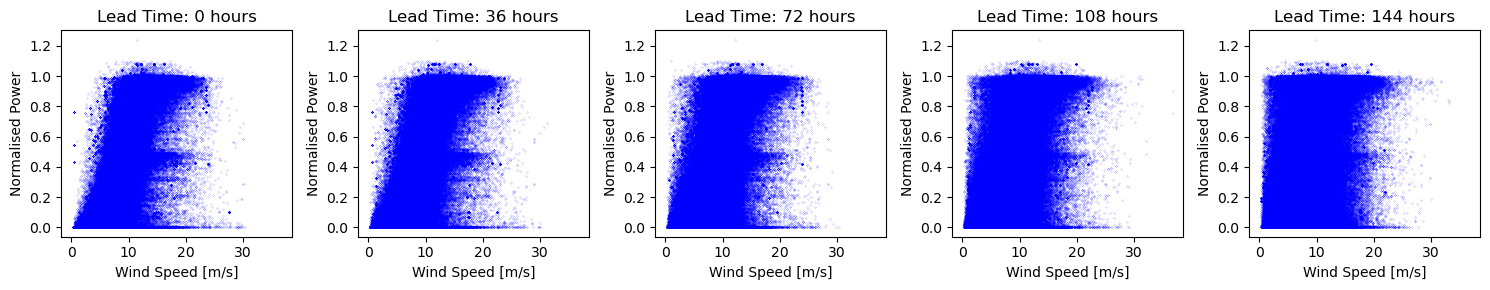

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import json

# Define lead times of interest
lead_times = [0, 36, 72, 108, 144]

# Define input directory
input_dir = r"E:\MA_data\WPPs+production+reforecast"

# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharex=True)

# Loop through lead times and plot data
for idx, lead_time in enumerate(lead_times):
    input_file = os.path.join(input_dir, f"WPPs+production+wind_lead_time_{lead_time}.json")
    
    # Load JSON data
    with open(input_file, 'r') as file:
        data = json.load(file)
    
    wind_speeds = []
    normalised_powers = []

    # Extract wind speed and normalised power
    for plant in data.values():
        capacity = plant["Capacity"]
        for entry in plant["Time Series"]:
            wind_speeds.append(entry[2])  # Wind speed
            normalised_powers.append(entry[1] / capacity)  # Normalised power

    # Plot data
    axes[idx].scatter(wind_speeds, normalised_powers, c="blue", s=0.005)
    axes[idx].set_title(f"Lead Time: {lead_time} hours")
    axes[idx].set_ylabel("Normalised Power")
    axes[idx].set_xlabel("Wind Speed [m/s]")

# Adjust layout
plt.tight_layout()
plt.show()
